# A2 assignment's notebook for Complex Networks at URV 2025

## Authors:

- Lobo Santos, Antonio
-  Kasa, Andras


## Part 1: Characterization of the community structure of networks with block structure

In [1]:
# Import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import infomap as im
from collections import defaultdict
import time
from sklearn.metrics import normalized_mutual_info_score
from collections import Counter
from math import log
import itertools

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)


#### Define SBM Parameters and Generate the Network

We first define our SBM parameters. The network is divided into 5 blocks of equal size. The intra-block connection probability (prr) is set to an example value of 0.16 and the inter-block connection probability (prs) is 0.02. A probability matrix is then built where diagonal entries correspond to `prr` and off-diagonals to `prs`.


In [2]:
# Define parameters
N = 300                   # Total number of nodes
nblocks = 5               # Number of blocks
block_size = N // nblocks # Equal block sizes
prr = 0.16                # Intra-block probability
prs = 0.02                # Inter-block probability

# Create list of block sizes
sizes = [block_size] * nblocks

# Create the probability matrix for SBM
p_matrix = [[prr if i == j else prs for j in range(nblocks)] for i in range(nblocks)]

# Print the parameters for verification
print("SBM Parameters:")
print(f"Total nodes: {N}")
print(f"Blocks: {nblocks}")
print(f"Block sizes: {sizes}")
print(f"Intra-block probability (prr): {prr}")
print(f"Inter-block probability (prs): {prs}")

SBM Parameters:
Total nodes: 300
Blocks: 5
Block sizes: [60, 60, 60, 60, 60]
Intra-block probability (prr): 0.16
Inter-block probability (prs): 0.02


### Generate the Synthetic SBM Network

We now use the `networkx.stochastic_block_model` function to generate our synthetic network with the specified SBM parameters.


In [3]:
def create_sbm_graph(N=300, nblocks=5, prr=0.16, prs=0.02, seed=None, save_pajek=False):
    """
    Generate a synthetic network using the stochastic block model (SBM) and return the NetworkX graph.
    
    Parameters:
    -----------
    N : int
        Total number of nodes.
    nblocks : int
        Number of blocks (communities). Assumes equal block sizes.
    prr : float
        Intra-block connection probability.
    prs : float
        Inter-block connection probability.
    seed : int or None
        Random seed for reproducibility.
    save_pajek : bool
        If True, the graph will be saved in Pajek format with a filename based on the parameters.
    
    Returns:
    --------
    G : networkx.Graph
        The generated SBM network.
    """
    block_size = N // nblocks
    sizes = [block_size] * nblocks

    # Create the probability matrix: prr for intra-block, prs for inter-block.
    p_matrix = [[prr if i == j else prs for j in range(nblocks)] for i in range(nblocks)]

    # Generate the SBM network using NetworkX.
    G = nx.stochastic_block_model(sizes, p_matrix, seed=seed)

    # Optionally, save the network in Pajek format.
    if save_pajek:
        filename = f"synthetic_network_N_{N}_blocks_{nblocks}_prr_{prr}_prs_{prs}.net"
        nx.write_pajek(G, filename)
    
    return G

G = create_sbm_graph(N, nblocks, prr, prs, seed=SEED, save_pajek=True)

# Print basic information about the generated network
print("Generated SBM Network:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Generated SBM Network:
Number of nodes: 300
Number of edges: 2182


c:\Python_3.10.2\lib\site-packages\networkx\readwrite\pajek.py:75: UserWarning: Node attribute block is not processed. Non-string attribute.
  warnings.warn(


### Finding Communities
In this section we will focus on identifying the communities on the previously generated graphs. First we will compute all communities using the following algorithms:

1. Infomap
2. Louvain
3. Greedy Modularity 
4. Girvan-Newman method (constranied and unconstrained)

In [4]:
 
def infomap_to_networkx_communities(mapping, partition):
    """
    Convert Infomap partition to list of sets (NetworkX communities format).
    
    Args:
        mapping (dict): Mapping from NetworkX nodes to Infomap nodes.
        partition (dict): Infomap partition (node -> module).
        
    Returns:
        list: List of sets where each set is a community.
    """
    # Convert partition to dict keyed by the original node names
    reverse_mapping = {v: k for k, v in mapping.items()}
    original_partition = {reverse_mapping[node]: module for node, module in partition.items()}
    
    # Group nodes by community
    communities = {}
    for node, community_id in original_partition.items():
        if community_id not in communities:
            communities[community_id] = set()
        communities[community_id].add(node)
    
    # Convert dict to list of sets
    return list(communities.values())
# 1. Define the two GN functions
def girvan_newman_constrained(G, k):
    """Force Girvan-Newman to find exactly k communities"""
    comp = nx.community.girvan_newman(G)
    
    for communities in comp:
        if len(communities) >= k:
            return list(communities)[:k]
    return list(communities)

def girvan_newman_unconstrained(G):
    """Let Girvan-Newman find communities naturally"""
    comp = nx.community.girvan_newman(G)
    next(comp)  # Skip first
    communities = next(comp)  # Get second
    return list(communities)

# 2. Single get_all_communities function with a parameter
def get_all_communities(G, block_size, nblocks, silent_infomap=True):
    """
    Get communities with either constrained or unconstrained Girvan-Newman
    """
    # INFOMAP
    infomap_wrapper = im.Infomap(silent=silent_infomap)
    mapping = infomap_wrapper.add_networkx_graph(G)
    infomap_wrapper.run()
    infomap_partition = infomap_wrapper.get_modules()
    communities_infomap = infomap_to_networkx_communities(mapping, infomap_partition)
    
    # LOUVAIN COMMUNITY
    communities_louvain = nx.community.louvain_communities(G)
    
    # GREEDY MODULARITY COMMUNITY
    communities_greedy = nx.community.greedy_modularity_communities(G)
    
    # GIRVAN-NEWMAN COMMUNITY - CHOOSE VERSION

    communities_girvan_newmanc = girvan_newman_constrained(G, k=nblocks)
    
    communities_girvan_newmanunc = girvan_newman_unconstrained(G)
    
    # GOLDEN STANDARD COMMUNITY
    communities_golden_standard = [set(range(i * block_size, (i + 1) * block_size)) for i in range(nblocks)]
    
    return {
        "infomap": communities_infomap,
        "louvain": communities_louvain,
        "greedy": communities_greedy,
        "girvan_newmanc": communities_girvan_newmanc,
        "girvan_newmanunc": communities_girvan_newmanunc,
        "golden_standard": communities_golden_standard
    }



In the code below, we tested the result of the get_communities function. It takes at least 10 minutes to run, so you might want to avoid using it.


In [5]:
communities = get_all_communities(G, block_size, nblocks)
print (communities) 


{'infomap': [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 110}, {60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119}, {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 120, 121, 122, 123, 124, 125, 126, 127}, {180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 

In [7]:
def analyze_specific_prr_values(prr_values=[0.02, 0.16, 1.00], seed=SEED):
    """
    Run community detection for specific prr values and save results as Pajek files.
    
    Args:
        prr_values: List of prr values to analyze
        seed: Random seed for reproducibility
    """
    print(f"Analyzing networks at specific prr values: {prr_values}")
    
    # Function to write communities in Pajek .clu format
    def write_pajek_communities(communities, filename):
        """Write communities to a Pajek .clu file"""
        # Flatten communities into a mapping from node to community ID
        node_to_comm = {}
        for comm_id, comm in enumerate(communities):
            for node in comm:
                node_to_comm[node] = comm_id + 1  # Pajek uses 1-based indexing
        
        # Get total number of nodes
        num_nodes = len(node_to_comm)
        
        # Write to file
        with open(filename, 'w') as f:
            f.write(f"*Vertices {num_nodes}\n")
            for node in range(num_nodes):
                # Use community ID if node exists, otherwise 1
                comm_id = node_to_comm.get(node, 1)
                f.write(f"{comm_id}\n")
        
        print(f"  Communities saved to {filename}")
    
    for prr in prr_values:
        print(f"\nProcessing network with prr = {prr:.2f}")
        
        # Create the graph
        G = create_sbm_graph(N, nblocks, prr, prs, seed=seed, save_pajek=False)
        
        # Save network
        net_filename = f"network_prr_{prr:.2f}.net"
        nx.write_pajek(G, net_filename)
        print(f"  Network saved as {net_filename}")
        
        # Run community detection
        communities = get_all_communities(G, block_size, nblocks, silent_infomap=True)
        
        # Save each algorithm's communities as separate .clu files
        for method, comm_list in communities.items():
            clu_filename = f"{method}_prr_{prr:.2f}.clu"
            write_pajek_communities(comm_list, clu_filename)
        
        # Print community information
        print("\nCommunity detection results:")
        for method, comm_list in communities.items():
            print(f"\n  {method}: {len(comm_list)} communities")
            for i, comm in enumerate(comm_list):
                # Print shortened version if community is large
                if len(comm) > 10:
                    comm_sample = list(sorted(comm))[:5] + ['...'] + list(sorted(comm))[-5:]
                    print(f"    Community {i+1}: {comm_sample} (size: {len(comm)})")
                else:
                    print(f"    Community {i+1}: {sorted(comm)}")
    
    print("\nAnalysis complete. Networks and communities saved as Pajek files.")

Using this function, we can create all .clu files and use them for plotting purposes. In the following steps, we used the functions provided on the GitHub page:
https://github.com/joaquincabezas/networkx_pajek_util/tree/master


In [8]:
analyze_specific_prr_values()

Analyzing networks at specific prr values: [0.02, 0.16, 1.0]

Processing network with prr = 0.02
  Network saved as network_prr_0.02.net
  Communities saved to infomap_prr_0.02.clu
  Communities saved to louvain_prr_0.02.clu
  Communities saved to greedy_prr_0.02.clu
  Communities saved to girvan_newmanc_prr_0.02.clu
  Communities saved to girvan_newmanunc_prr_0.02.clu
  Communities saved to golden_standard_prr_0.02.clu

Community detection results:

  infomap: 26 communities
    Community 1: [0, 3, 17, 20, 56, '...', 237, 247, 263, 275, 276] (size: 18)
    Community 2: [1, 74, 125, 187, 192, 201, 266]
    Community 3: [2, 28, 67, 71, 114, '...', 146, 152, 267, 287, 296] (size: 14)
    Community 4: [4, 19, 26, 38, 43, '...', 249, 268, 273, 279, 290] (size: 29)
    Community 5: [5, 6, 11, 12, 16, '...', 245, 282, 283, 286, 288] (size: 26)
    Community 6: [7, 8, 10, 60, 105, 217, 235, 269]
    Community 7: [9, 42, 81, 94, 153, '...', 169, 194, 212, 228, 248] (size: 11)
    Community 8: 

Let us move the community files to the SBM subfolder

In [12]:
import os
import shutil

def move_files_to_sbm_folder():
    """
    Move all Pajek files (.net and .clu) created by analyze_specific_prr_values
    to a subfolder named 'SBM'.
    """
    # Create SBM folder if it doesn't exist
    if not os.path.exists('SBM'):
        os.makedirs('SBM')
        print("Created SBM folder")
    
    # Find all .net and .clu files in the current directory
    pajek_files = []
    for file in os.listdir('.'):
        if file.endswith('.net') or file.endswith('.clu'):
            pajek_files.append(file)
    
    # Move files to SBM folder
    moved_count = 0
    for file in pajek_files:
        source = file
        destination = os.path.join('SBM', file)
        try:
            shutil.move(source, destination)
            moved_count += 1
            print(f"Moved: {file} → SBM/{file}")
        except Exception as e:
            print(f"Error moving {file}: {e}")
    
    print(f"\nMoved {moved_count} files to the SBM folder")

move_files_to_sbm_folder()

Created SBM folder
Moved: girvan_newmanc_prr_0.02.clu → SBM/girvan_newmanc_prr_0.02.clu
Moved: girvan_newmanc_prr_0.16.clu → SBM/girvan_newmanc_prr_0.16.clu
Moved: girvan_newmanc_prr_1.00.clu → SBM/girvan_newmanc_prr_1.00.clu
Moved: girvan_newmanunc_prr_0.02.clu → SBM/girvan_newmanunc_prr_0.02.clu
Moved: girvan_newmanunc_prr_0.16.clu → SBM/girvan_newmanunc_prr_0.16.clu
Moved: girvan_newmanunc_prr_1.00.clu → SBM/girvan_newmanunc_prr_1.00.clu
Moved: golden_standard_prr_0.02.clu → SBM/golden_standard_prr_0.02.clu
Moved: golden_standard_prr_0.16.clu → SBM/golden_standard_prr_0.16.clu
Moved: golden_standard_prr_1.00.clu → SBM/golden_standard_prr_1.00.clu
Moved: greedy_prr_0.02.clu → SBM/greedy_prr_0.02.clu
Moved: greedy_prr_0.16.clu → SBM/greedy_prr_0.16.clu
Moved: greedy_prr_1.00.clu → SBM/greedy_prr_1.00.clu
Moved: infomap_prr_0.02.clu → SBM/infomap_prr_0.02.clu
Moved: infomap_prr_0.16.clu → SBM/infomap_prr_0.16.clu
Moved: infomap_prr_1.00.clu → SBM/infomap_prr_1.00.clu
Moved: louvain_prr

In [19]:
def set_color_nodes(communities, G):
    colors = plt.cm.jet(np.linspace(0, 1, len(communities)))
    community_node = {}
    count_community = 0

    for community in communities:
        for node in community:
            community_node[node] = count_community
        count_community = count_community + 1

    color_nodes = []
    for node in G.nodes():
        color_nodes.append(colors[community_node[node]])
    
    return color_nodes

import os
from utils import read_pajek_communities

def plot_prr_comparison(G, communities_dict, positions, method=""):
    prr_values = sorted(communities_dict.keys())
    num_prr = len(prr_values)
    
    fig, axes = plt.subplots(1, num_prr, figsize=(5 * num_prr, 5))
    
    if num_prr == 1:
        axes = [axes]
    
    for ax, prr in zip(axes, prr_values):
        communities = communities_dict[prr]
        color_nodes = set_color_nodes(communities, G)
        nx.draw(
            G, 
            node_color=color_nodes, 
            pos=positions, 
            with_labels=False, 
            node_size=20, 
            alpha=0.8, 
            edge_color="gray", 
            ax=ax
        )
        ax.set_title(f"prr = {prr}")
        ax.axis("off")
    
    fig.suptitle(f"Communities for different prr values using {method}", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{method}_comparison.png", dpi=300)
    plt.show()

def load_communities_from_files(folder="SBM"):
    communities_dict = {}
    
    for filename in os.listdir(folder):
        if filename.endswith(".clu"):
            parts = filename.split("_")
            method_parts = []
            prr = None
            
            for i, part in enumerate(parts):
                if part == "prr" and i+1 < len(parts):
                    prr = float(parts[i+1].replace(".clu", ""))
                elif part != "prr" and "prr" not in parts[:i]:
                    method_parts.append(part)
            
            method = "_".join(method_parts)
            
            if prr is not None and method:
                communities = read_pajek_communities(os.path.join(folder, filename))
                
                if method not in communities_dict:
                    communities_dict[method] = {}
                
                communities_dict[method][prr] = communities
    
    return communities_dict

Plotting communities for method: girvan_newmanc


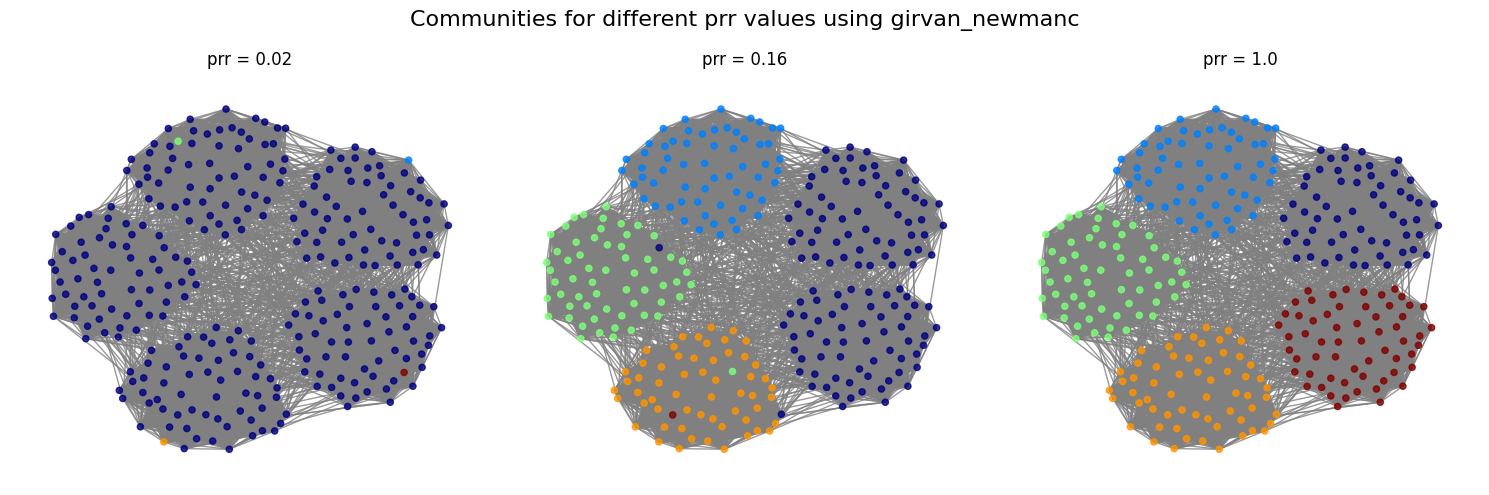

Plotting communities for method: girvan_newmanunc


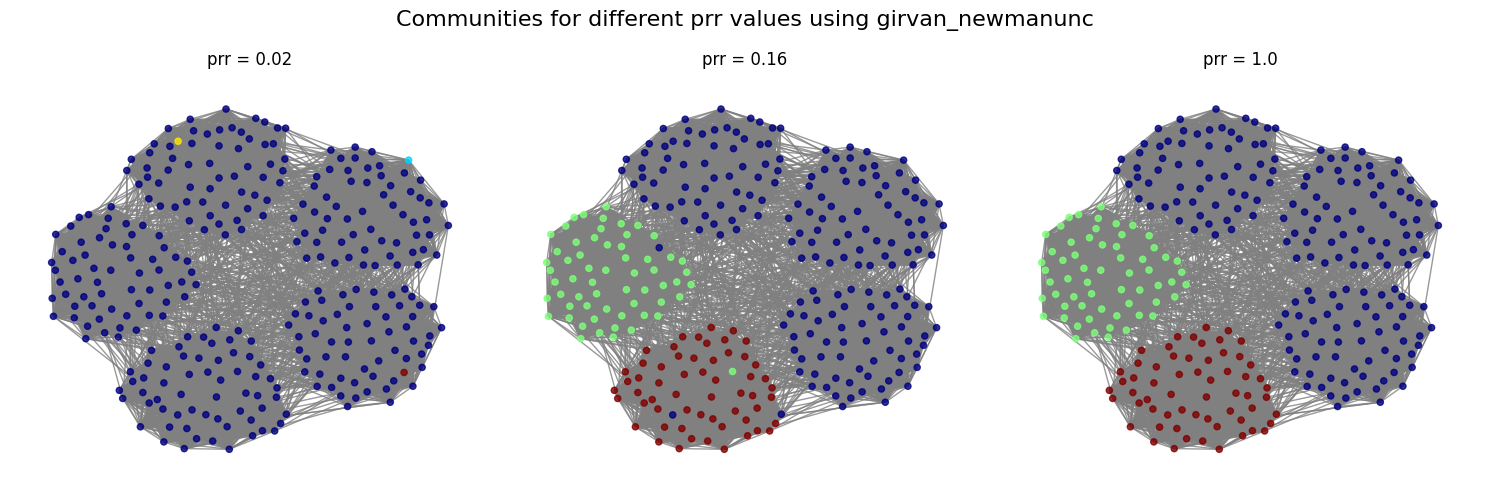

Plotting communities for method: golden_standard


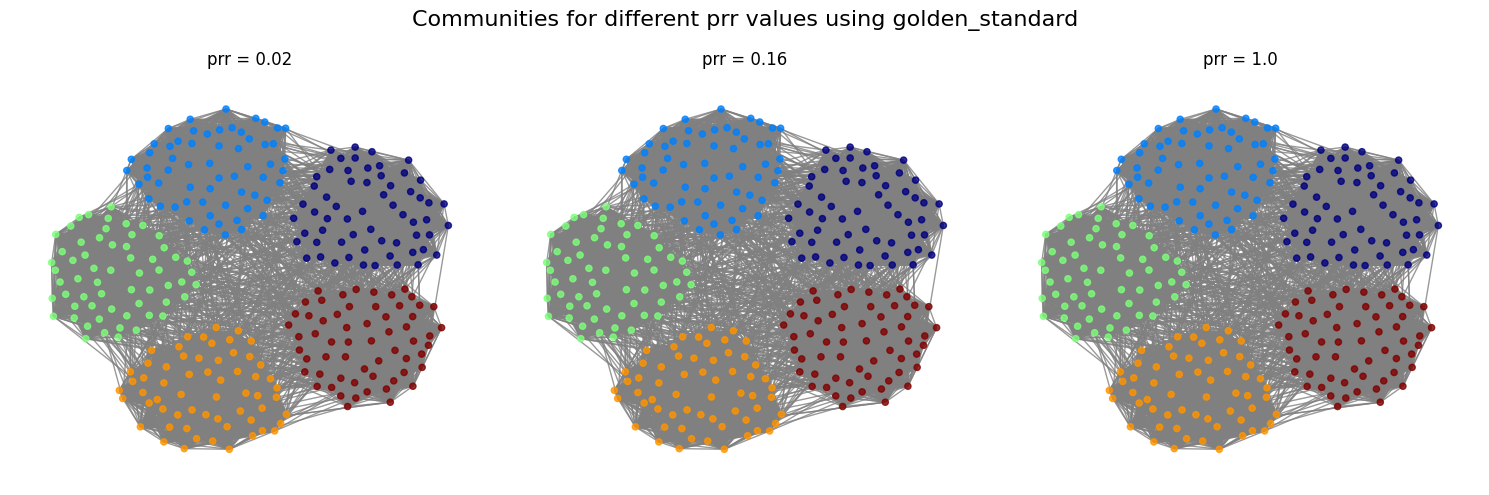

Plotting communities for method: greedy


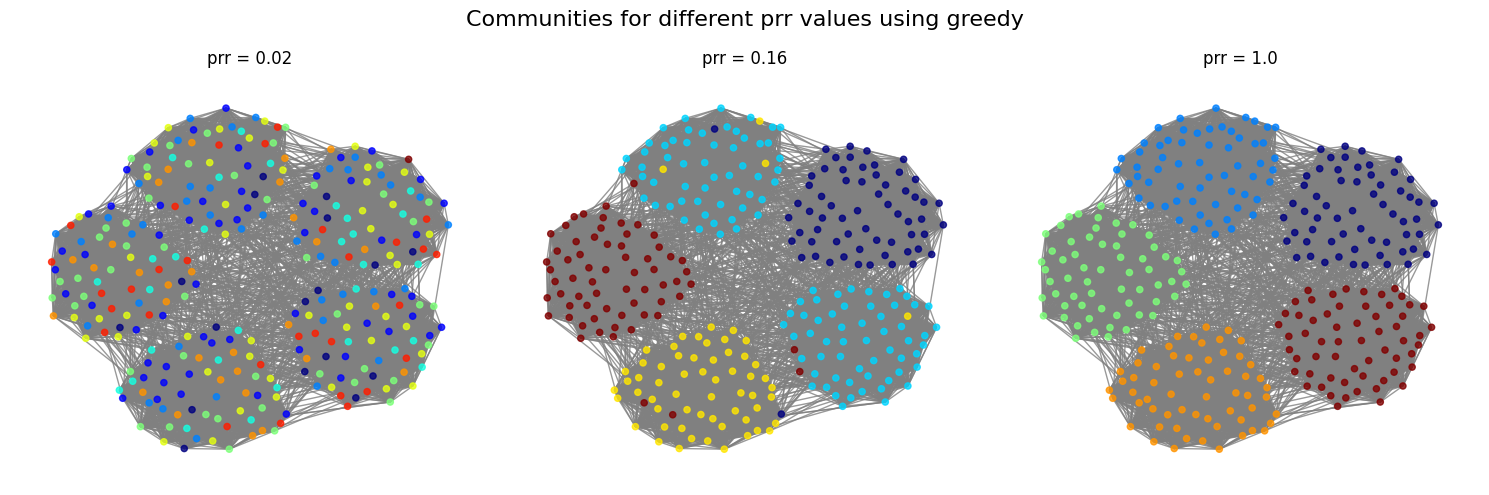

Plotting communities for method: infomap


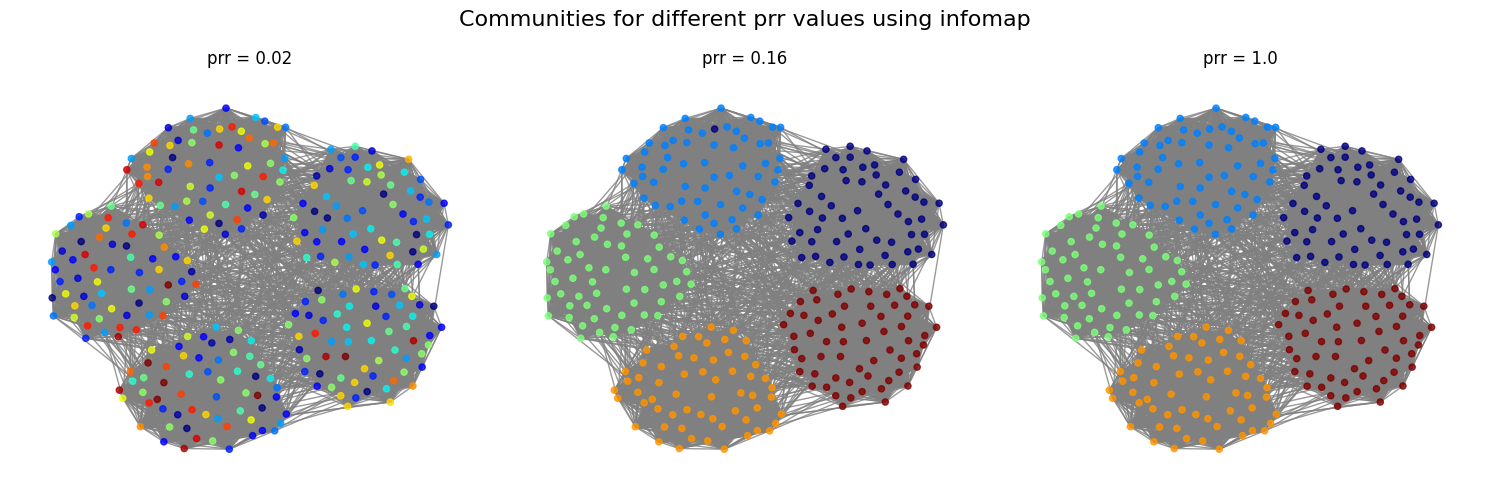

Plotting communities for method: louvain


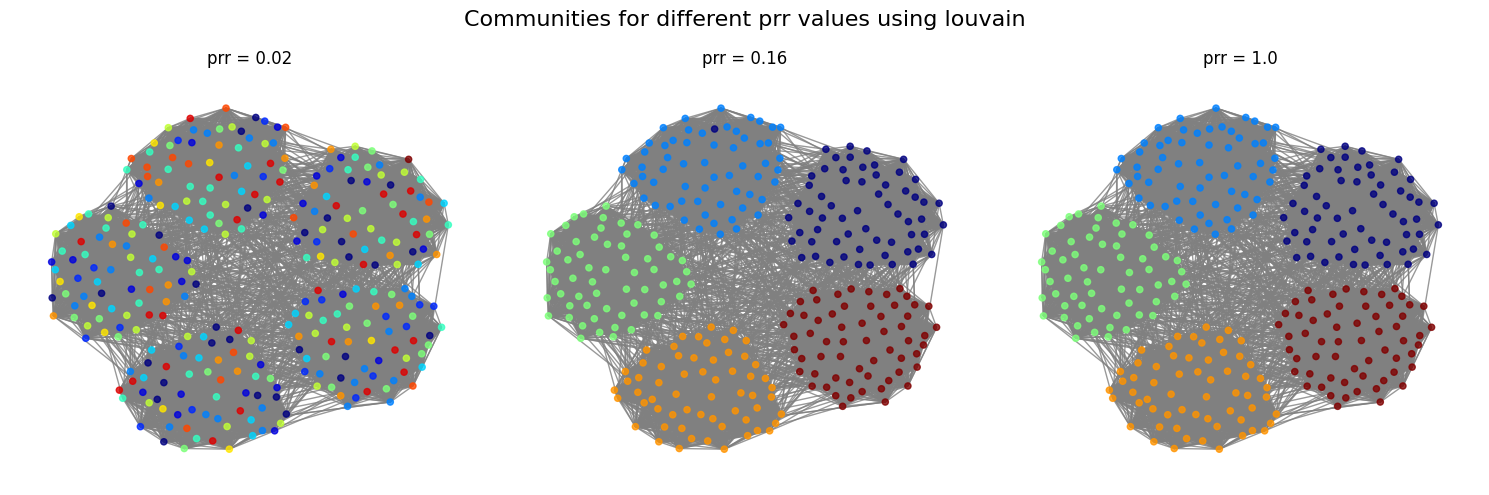

In [20]:
# Load all methods and prr values
communities_dict = load_communities_from_files(folder="SBM")

# Get positions using prr=1 for all methods
G = create_sbm_graph(N, nblocks, 1, prs, seed=SEED, save_pajek=False)
positions = nx.kamada_kawai_layout(G)

# Plot for each method
for method, prr_communities in communities_dict.items():
    print(f"Plotting communities for method: {method}")
    plot_prr_comparison(G, prr_communities, positions, method=method)

We define the evaluation functions to compute the metrics

In [18]:
from collections import defaultdict, Counter
from math import log
import networkx as nx
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import normalized_mutual_info_score

def partition_to_labels(partition):
    """
    Convert a partition (list of sets) into a dictionary mapping each node to its community id.
    """
    labels = {}
    for label, community in enumerate(partition):
        for node in community:
            labels[node] = label
    return labels

def compute_entropy(labels):
    counts = Counter(labels)
    total = len(labels)
    return -sum((count/total) * log(count/total) for count in counts.values() if count/total > 0)

def compute_mutual_information(y_true, y_pred):
    total = len(y_true)
    counter_true = Counter(y_true)
    counter_pred = Counter(y_pred)
    joint_counts = Counter(zip(y_true, y_pred))
    mi = 0.0
    for (t, p), joint in joint_counts.items():
        p_tp = joint / total
        p_t = counter_true[t] / total
        p_p = counter_pred[p] / total
        mi += p_tp * log(p_tp / (p_t * p_p))
    return mi

def normalized_variation_of_information(y_true, y_pred):
    """
    Compute the Variation of Information (VI) and then normalize it.
    VI = H(true) + H(pred) - 2I(true, pred). The normalized VI is obtained by dividing by log(n)
    where n is the number of nodes.
    """
    H_true = compute_entropy(y_true)
    H_pred = compute_entropy(y_pred)
    I = compute_mutual_information(y_true, y_pred)
    VI = H_true + H_pred - 2 * I
    normalization = log(len(y_true))
    return VI / normalization if normalization != 0 else VI

def jaccard_index_partition(y_true, y_pred):
    """
    Compute a pair-count based Jaccard Index for two partitions.
    For all pairs of nodes, count a pair if the nodes are in the same community in one or both 
    partitions, and count an agreement if they are together in both.
    """
    n = len(y_true)
    agree = 0  # pairs that are in the same community in both partitions
    union = 0  # pairs that are in the same community in at least one partition
    for i in range(n):
        for j in range(i + 1, n):
            same_true = (y_true[i] == y_true[j])
            same_pred = (y_pred[i] == y_pred[j])
            if same_true or same_pred:
                union += 1
            if same_true and same_pred:
                agree += 1
    return agree / union if union != 0 else 0

def evaluate_partition(golden_partition, algorithm_partition, G, prr):
    """
    Evaluate a community partition against the golden standard.
    
    Arguments:
        golden_partition: List[Set] representing the true communities.
        algorithm_partition: List[Set] representing communities found by an algorithm.
        G: networkx graph for computing modularity.
        prr: A parameter (e.g., node removal probability) to track the evolution.
    
    Returns:
        dict: A dictionary containing:
            - 'prr': given prr value.
            - 'num_communities': number of communities in the algorithm partition.
            - 'modularity': modularity of the algorithm partition.
            - 'normalized_mutual_information': NMI between golden and algorithm partitions.
            - 'normalized_variation_of_information': normalized VI between partitions.
            - 'jaccard_index': Jaccard index for the partitions (pair-based).
    """
    metrics = {}
    metrics['prr'] = prr
    metrics['num_communities'] = len(algorithm_partition)
    
    # Compute modularity using networkx
    metrics['modularity'] = modularity(G, algorithm_partition)
    
    # Convert partitions to label assignments
    alg_labels_dict = partition_to_labels(algorithm_partition)
    golden_labels_dict = partition_to_labels(golden_partition)
    
    # Ensure both partitions cover the same set of nodes;
    # here we assume that golden_partition contains all nodes.
    common_nodes = list(golden_labels_dict.keys())
    
    y_true = [golden_labels_dict[node] for node in common_nodes]
    y_pred = [alg_labels_dict[node] for node in common_nodes]
    
    # Compute Normalized Mutual Information (using arithmetic normalization)
    metrics['normalized_mutual_information'] = normalized_mutual_info_score(
        y_true, y_pred, average_method='arithmetic'
    )
    
    # Compute Normalized Variation of Information
    metrics['normalized_variation_of_information'] = normalized_variation_of_information(y_true, y_pred)
    
    # Compute Jaccard Index for community partitions
    metrics['jaccard_index'] = jaccard_index_partition(y_true, y_pred)
    
    return metrics

evaluate_partition(communities["golden_standard"], communities["infomap"], G, prr)

{'prr': 0.16,
 'num_communities': 5,
 'modularity': 0.46221585491157124,
 'normalized_mutual_information': 0.9894489329632018,
 'normalized_variation_of_information': 0.005954292360321595,
 'jaccard_index': 0.9866442199775534}

Now we are going to plot each of the error metrics with respect to prr

In [13]:
def iterate_and_plot_comparison(step=0.05):
    """
    Runs two versions of community detection - one with constrained Girvan-Newman and one with unconstrained.
    
    Arguments:
        step: Step size for prr (default is 0.05)
        
    Returns:
        None. The function creates comparison plots.
    """
    # List to store prr values and metrics
    prr_values = []
    
    # Metrics for constrained GN
    const_metrics = {
        'nmi': [], 'vi': [], 'jaccard': [], 'modularity': [], 'num_comm': []
    }
    
    # Metrics for unconstrained GN
    unconst_metrics = {
        'nmi': [], 'vi': [], 'jaccard': [], 'modularity': [], 'num_comm': []
    }
    
    # Iterate over prr values
    for prr in np.arange(0, 0.1 + step, step):
        print(f"\nProcessing prr = {prr:.2f}")
        prr_values.append(prr)

        # Create a graph for this prr value
        G = create_sbm_graph(N, nblocks, prr, prs, seed=SEED, save_pajek=False)
        golden_standard = [set(range(i * block_size, (i + 1) * block_size)) for i in range(nblocks)]
        
        # Run constrained Girvan-Newman (k=nblocks)
        print("Running constrained Girvan-Newman...")
        start_time = time.time()
        
        # This is your existing implementation that forces exactly nblocks communities
        communities_const = girvan_newman_communities(G, k=nblocks)
        
        const_time = time.time() - start_time
        print(f"  Time: {const_time:.2f}s, Communities: {len(communities_const)}")
        
        # Evaluate constrained GN
        metrics_const = evaluate_partition(golden_standard, communities_const, G, prr)
        const_metrics['nmi'].append(metrics_const['normalized_mutual_information'])
        const_metrics['vi'].append(metrics_const['normalized_variation_of_information'])
        const_metrics['jaccard'].append(metrics_const['jaccard_index'])
        const_metrics['modularity'].append(metrics_const['modularity'])
        const_metrics['num_comm'].append(metrics_const['num_communities'])
        
        # Run unconstrained Girvan-Newman (standard NetworkX)
        print("Running unconstrained Girvan-Newman...")
        start_time = time.time()
        
        # Use standard NetworkX implementation, take second partition
        import itertools
        comp = nx.community.girvan_newman(G)
        communities_unconst = None
        for i, communities in enumerate(itertools.islice(comp, 2)):
            if i == 1:
                communities_unconst = list(communities)
        
        # If we didn't get a second partition, use the first one
        if communities_unconst is None:
            comp = nx.community.girvan_newman(G)
            communities_unconst = list(next(comp))
        
        unconst_time = time.time() - start_time
        print(f"  Time: {unconst_time:.2f}s, Communities: {len(communities_unconst)}")
        
        # Evaluate unconstrained GN
        metrics_unconst = evaluate_partition(golden_standard, communities_unconst, G, prr)
        unconst_metrics['nmi'].append(metrics_unconst['normalized_mutual_information'])
        unconst_metrics['vi'].append(metrics_unconst['normalized_variation_of_information'])
        unconst_metrics['jaccard'].append(metrics_unconst['jaccard_index'])
        unconst_metrics['modularity'].append(metrics_unconst['modularity'])
        unconst_metrics['num_comm'].append(metrics_unconst['num_communities'])
    
    # Create comparison plots
    metrics = ['nmi', 'vi', 'jaccard', 'modularity', 'num_comm']
    titles = ['Normalized Mutual Information', 'Variation of Information', 
              'Jaccard Index', 'Modularity', 'Number of Communities']
    ylabels = ['NMI', 'VI', 'Jaccard Index', 'Modularity', '# Communities']
    
    for metric, title, ylabel in zip(metrics, titles, ylabels):
        plt.figure(figsize=(10, 6))
        plt.plot(prr_values, const_metrics[metric], 'o-', label='Constrained GN', color='blue')
        plt.plot(prr_values, unconst_metrics[metric], 's--', label='Unconstrained GN', color='red')
        plt.xlabel("prr", fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.title(f"{title} Comparison", fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{metric}_comparison.png", dpi=300)
        plt.show()
    
    return prr_values, const_metrics, unconst_metrics

In [15]:
iterate_and_plot_comparison()


Processing prr = 0.00
Running constrained Girvan-Newman...


NameError: name 'girvan_newman_communities' is not defined